In [1]:
# define logging and working directory
import os
import io
import sys
import logging
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
from pyforest import *

# define jupyter params
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%reload_ext autoreload
%autoreload 2

# define GPU id to use
# 0 = 1080
# 1 = Titan
# 2 = Titan
gpu_id = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
current_gpu = '/device:GPU:0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# import own modules and utils
from src.utils.Tensorflow_helper import show_available_gpus
from src.utils.utils_io import Console_and_file_logger, ensure_dir
from src.utils.myshow import myshow, myshow3d
import src.utils.medley_metrics as m_metrics
import src.utils.my_metrics as metr
from src.models.ModelManager import get_model, load_pretrained_model
from src.data.dataset import get_img_msk_files_from_split_dir, get_z_position_from_filename, get_t_position_from_filename, get_patient_name_from_filename
from src.data.generators import DataGenerator, get_samples
from src.utils.KerasCallbacks import TrainValTensorBoard,CustomImageWriter, WeightsSaver
from src.visualization.visualize import show_slice, show_slice_transparent
from src.utils.KerasCallbacks import get_callbacks

# import tools for preprocessing and model configuration
import keras
from keras import backend as K
from keras.models import load_model
from keras.models import model_from_json
from keras.utils import plot_model
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.contrib.memory_stats import BytesInUse
from multiprocessing import Process

# define aditional imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
import json
from ipywidgets import interact

# define experiment name for report, model and log paths + filenames
EXPERIMENT = '2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore'
now = datetime.datetime.now()

# image params
# Greyscale images
IMG_CHANNELS = 1
# RV = 1 = Y[...,0] 
# Myo = 2 = Y[...,1] 
# LV = 3 = Y[...,2]
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
AUGMENT = False
AUGMENT_GRID = True
RESAMPLE = False
SHUFFLE = True

SCALER = 'MinMax' # Standard, Robust


AUGMENT_IMAGE_PARAMS = dict(  # samplewise_center=True,
                # samplewise_std_normalization=True,
                #horizontal_flip=True,
                #vertical_flip=True,
                #rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                # fill_mode='nearest'
            )
AUGMENT_MASK_PARAMS = dict(  # samplewise_center=True,
                # samplewise_std_normalization=True,
                #horizontal_flip=True,
                #vertical_flip=True,
                #rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                fill_mode='nearest',
                # dtype=np.bool
            )

# path params
DATASET = 'tetra'  # 'acdc' # or 'tetra'
TRAIN_PATH = 'data/raw/tetra/2D/train/'
#VAL_PATH = 'C:/Users/s.koehler/Desktop/2D/val/'
#TEST_PATH = 'C:/Users/s.koehler/Desktop/2D/test/'
#TRAIN_PATH = 'data/raw/ACDC/2D/train/'
VAL_PATH = 'data/raw/tetra/2D/val/'
TEST_PATH = 'data/raw/ACDC/2D/val/'

MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))

# training params
ARCHITECTURE = '2D'
DIM = [224, 224]
SPACING = [1.0, 1.0] # used by sitk, opposite order of DIM !
SEED = 42
BATCHSIZE =  24 # 64, 32, 16, 1
EPOCHS = 150
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'dice_coef_labels'
MONITOR_MODE = 'max'

# Network params
OPTIMIZER = 'Adam'  # Adam, Adagrad, softmax # https://keras.io/optimizers/
ACTIVATION = 'elu'  # 'elu' --> works well with binary_crossentropy and bce_dice_loss, relu does not work, it clips negative values, bse does return negative values
LEARNING_RATE = 0.001
DECAY = 0.0
EPSILON = 1e-08
DROPOUT_L1_L2 = 0.4 # best with 0.4 and other 0.5
DROPOUT_L3_L4 = 0.5
DROPOUT_L5 = 0.5
BATCH_NORMALISATION = True

#LOSS_FUNCTION = metr.bce_dice_loss
LOSS_FUNCTION = metr.bce_dice_jac_loss  # 'binary_crossentropy'--> 91 IOU, bce_dice_loss --> 94 IOU
#LOSS_FUNCTION = metr.weighted_cce_dice_coef([1,5,5,3])
#LOSS_FUNCTION = keras.losses.categorical_crossentropy
#LOSS_FUNCTION = metr.weighted_categorical_crossentropy([1,5,10,3])
#LOSS_FUNCTION = keras.losses.binary_crossentropy
metrics = [
    #keras.metrics.binary_accuracy,
    #keras.metrics.kullback_leibler_divergence,
    #metr.competitionMetric2,
    #metr.bce_dice_loss,
    #metr.bce_dice_iou_loss,
    metr.bce_dice_jac_loss,
    metr.dice_coef,
    metr.dice_coef_labels,
    metr.dice_coef_background,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv,
   #metr.mean_iou,
    #metr.mean_iou_myo,
    #metr.mean_iou_lv,
    #metr.mean_iou_rv,
    #metr.iou_core,
    #metr.iou_core_background,
    #metr.iou_core_myo,
    #metr.iou_core_lv,
    #metr.iou_core_rv,
    #metr.iou_loss,
    #metr.jaccard_coef,
    #metr.jaccard_coef_labels,
    #metr.jaccard_coef_background,
    #metr.jaccard_coef_myo,
    #metr.jaccard_coef_lv,
    #metr.jaccard_coef_rv,
    #metr.jaccard_distance_loss,
    #metr.tversky_loss,
    
]

# make sure logging directories are available
Console_and_file_logger(EXPERIMENT, logging.INFO)


# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(locals(), False)

# set warnings lvl for skimage
#warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
# define a Tensorflow config
#tf_config = tf.ConfigProto()
tf_config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True)
#tf_config.gpu_options.allow_growth = True
tf_session = tf.Session(config=tf_config)
tf.keras.backend.set_session(tf_session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11337902923868109457
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10887242957
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16046605330948938863
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


2019-08-29 14:11:44,843 INFO -------------------- Start --------------------
2019-08-29 14:11:44,843 INFO Working directory: E:\sven\git\cardio.
2019-08-29 14:11:44,843 INFO Log file: ./logs/2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore.log
2019-08-29 14:11:44,858 INFO config:
 {
    "ACTIVATION": "elu",
    "ARCHITECTURE": "2D",
    "AUGMENT": false,
    "AUGMENT_GRID": true,
    "AUGMENT_IMAGE_PARAMS": {
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "zoom_range": 0.1
    },
    "AUGMENT_MASK_PARAMS": {
        "fill_mode": "nearest",
        "height_shift_range": 0.1,
        "width_shift_range": 0.1,
        "zoom_range": 0.1
    },
    "BATCHSIZE": 24,
    "BATCH_NORMALISATION": true,
    "CONFIG_PATH": "reports/configs/2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore\\2019-08-29_14_11",
    "DATASET": "tetra",
    "DECAY": 0.0,
    "DIM": [
        224,
        224
    ],
  

In [2]:
# load all images and masks
# create an image slice wrapper per image
# this wrapper encapuslates the preprocessing when it is needed by the datagenerator
# separate folders for train, validation, test

"""
X_train, Y_train = get_img_msk_files_from_split_dir(path=TRAIN_PATH)
X_val, Y_val = get_img_msk_files_from_split_dir(path=VAL_PATH)
X_test, Y_test = get_img_msk_files_from_split_dir(path=TEST_PATH)
"""
# load only slices from the lower, middle or upper part, all
X_train, Y_train = get_samples(path=TRAIN_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_val, Y_val = get_samples(path=VAL_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)
X_test, Y_test = get_samples(path=TEST_PATH, samples=0, part='all', no_patients = 0, preprocessed=False)


logging.info('train images: {}'.format(len(X_train)))
logging.info('train masks: {}'.format(len(Y_train)))
logging.info('validation images: {}'.format(len(X_val)))
logging.info('validation masks: {}'.format(len(Y_val)))
logging.info('test images: {}'.format(len(X_test)))
logging.info('test masks: {}'.format(len(Y_test)))



2019-08-29 14:11:45,842 INFO selected patients: ['0003-04NEJQUZ-2007-03-13', '0006-0AE4R74L-1900-01-01', '0007-0HQQW4ZN-2007-05-23', '0008-0PTV75MP-2005-06-27', '0010-0RPELLU8-2007-02-13', '0013-13JLP3HN-2007-05-22', '0014-1DRHF745-2005-09-01', '0016-1E4PF7MR-2006-07-06', '0018-1E8MCV9L-2005-12-15', '0034-1Y8H8XLE-2007-03-22', '0042-24YLF77L-2007-11-19', '0046-2CVUG1C5-2006-09-06', '0049-2FUH59VD-2006-08-24', '0051-2HQVK81W-2005-03-11', '0059-2WHFP73X-2007-03-28', '0066-2Y9U5LLC-2006-07-24', '0068-3E8U83K5-2006-04-01', '0070-3E90836W-2006-05-23', '0073-3EX293QC-2006-06-19', '0076-3HYXWJWW-2006-11-17', '0081-3U3KT9LV-2006-12-19', '0084-3WRWDJPC-2004-05-26', '0086-44U3AGET-2006-08-01', '0095-4A8MPQF4-2005-03-15', '0100-4HD5X727-2006-02-16', '0106-4PWV5NAX-2008-09-30', '0107-4Q0TDELR-2007-03-29', '0109-4QGENZMT-2007-02-22', '0116-5CXHN75U-2006-08-02', '0117-5JGEZLYC-2007-09-25', '0124-5T8DXCQ2-2006-10-01', '0127-5W8RFCJD-2005-04-18', '0129-5YX47QXL-2006-10-13', '0131-68UAYTYD-2005-10-01',

In [3]:
# Define datagenerator
#logging.getLogger().setLevel(logging.DEBUG)
logging.info('Build DataGenerators')
#batch_generator = DataGenerator2D(X_train, Y_train ,BATCHSIZE, dim=(IMG_WIDTH, IMG_HEIGHT), spacing=(SPACING_X,SPACING_Y), augment=AUGMENT, config=config)
#validation_generator = DataGenerator2D(X_val, Y_val ,BATCHSIZE, dim=(IMG_WIDTH, IMG_HEIGHT), spacing=(SPACING_X,SPACING_Y), augment=AUGMENT, config=config)
#test_generator = DataGenerator2D(X_test, Y_test, BATCHSIZE, dim=(IMG_WIDTH, IMG_HEIGHT), spacing=(SPACING_X,SPACING_Y), config=config)
batch_generator = DataGenerator(X_train, Y_train, config=config)
config['AUGMENT_GRID'] = False
validation_generator = DataGenerator(X_val, Y_val , config=config)
test_generator = DataGenerator(X_test, Y_test, config=config)

2019-08-29 14:11:47,137 INFO Build DataGenerators
2019-08-29 14:11:47,137 INFO Create DataGenerator
2019-08-29 14:11:47,153 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 24
 Scaler: MinMax
 Images: 10342 
 Augment_grid: True
2019-08-29 14:11:47,153 INFO No augmentation
2019-08-29 14:11:47,153 INFO Create DataGenerator
2019-08-29 14:11:47,153 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 24
 Scaler: MinMax
 Images: 1870 
 Augment_grid: False
2019-08-29 14:11:47,153 INFO No augmentation
2019-08-29 14:11:47,153 INFO Create DataGenerator
2019-08-29 14:11:47,153 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 24
 Scaler: MinMax
 Images: 434 
 Augment_grid: False
2019-08-29 14:11:47,153 INFO No augmentation


In [4]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(validation_generator), 1)):
    global x, y
    x, y = validation_generator.__getitem__(batch)


interactive(children=(IntSlider(value=38, description='batch', max=77), Output()), _dom_classes=('widget-inter…

In [5]:
@interact
def select_image_in_batch(im = (0,config['BATCHSIZE'], 1)):
    logging.getLogger().setLevel(logging.INFO)
    #show_slice(x[im], y[im])
    show_slice_transparent(x[im], y[im])
    plt.show()

interactive(children=(IntSlider(value=12, description='im', max=24), Output()), _dom_classes=('widget-interact…

In [6]:
@interact
def interact_load_pretrained_model(config_file=glob.glob('reports/configs/2D/**/**/*.json', recursive=False), load=False):
    """
    load past config for model training 
    """
    # load config with all params into global namespace
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config = json.loads(data_file.read())
        #globals()['MODEL_PATH'] = config['MODEL_PATH']
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
        try:
            # load model
            globals()['model'] = load_pretrained_model(config, metrics)
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=('reports/configs/2D\\unet_acdc_bce_dice_jac…

In [6]:
# create model
logging.info('Create model')
model = get_model(config, metrics)
model.summary()

2019-08-29 14:11:59,060 INFO Create model
2019-08-29 14:12:04,229 INFO Optimizer: Adam


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
plot_model(model, to_file='unet.svg', show_shapes=True)

In [8]:
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
with tf.device(current_gpu):
    logging.info('Fit model, start trainings process')
    # fit model with trainingsgenerator
    results = model.fit_generator(
        generator=batch_generator,
        epochs=EPOCHS,
        callbacks=get_callbacks(config, batch_generator, validation_generator),
        steps_per_epoch = len(batch_generator),
        validation_data=validation_generator,
        initial_epoch=initial_epoch,
        max_queue_size=30,
        workers=20,
        verbose=1)


2019-08-29 14:12:06,694 INFO Fit model, start trainings process
2019-08-29 14:12:07,287 INFO selected patients: ['0116-5CXHN75U-2006-08-02'] from: 151
2019-08-29 14:12:07,302 INFO Create DataGenerator
2019-08-29 14:12:07,302 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 15 
 Augment_grid: False
2019-08-29 14:12:07,302 INFO No augmentation
2019-08-29 14:12:07,458 INFO selected patients: ['0514-Q0QN3J15-2005-05-12'] from: 25
2019-08-29 14:12:07,458 INFO Create DataGenerator
2019-08-29 14:12:07,458 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 15 
 Augment_grid: False
2019-08-29 14:12:07,458 INFO No augmentation
2019-08-29 14:12:07,973 INFO selected patients: ['0116-5CXHN75U-2006-08-02'] from: 151
2019-08-29 14:12:07,989 INFO Create DataGenerator
2019-08-29 14:12:07,989 INFO Datagenerator created with: 
 shape: [224, 224]
 batchsize: 2
 Scaler: MinMax
 Images: 35 
 Augment_grid: False
2019-08-29 14

Epoch 1/150
430/430 [==============================] - 154s 357ms/step - loss: -0.0773 - bce_dice_jac_loss: -0.0773 - dice_coef: 0.5015 - dice_coef_labels: 0.2769 - dice_coef_background: 0.6375 - dice_coef_myo: 0.2000 - dice_coef_lv: 0.2922 - dice_coef_rv: 0.3278 - val_loss: -0.6528 - val_bce_dice_jac_loss: -0.6528 - val_dice_coef: 0.6400 - val_dice_coef_labels: 0.6857 - val_dice_coef_background: 0.6361 - val_dice_coef_myo: 0.6353 - val_dice_coef_lv: 0.6820 - val_dice_coef_rv: 0.7139


2019-08-29 14:15:14,551 INFO Saved model to disk: models\2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore\2019-08-29_14_11



Epoch 00001: dice_coef_labels improved from -inf to 0.27695, saving model to models\2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore\2019-08-29_14_11\checkpoint.h5
Epoch 2/150
430/430 [==============================] - 135s 315ms/step - loss: -0.7776 - bce_dice_jac_loss: -0.7776 - dice_coef: 0.6297 - dice_coef_labels: 0.7966 - dice_coef_background: 0.6172 - dice_coef_myo: 0.7080 - dice_coef_lv: 0.8653 - dice_coef_rv: 0.7983 - val_loss: -0.8040 - val_bce_dice_jac_loss: -0.8040 - val_dice_coef: 0.6366 - val_dice_coef_labels: 0.8200 - val_dice_coef_background: 0.6242 - val_dice_coef_myo: 0.7657 - val_dice_coef_lv: 0.9048 - val_dice_coef_rv: 0.7999

Epoch 00002: dice_coef_labels improved from 0.27695 to 0.79658, saving model to models\2D/batchnorm/unet_tetra_spacing1_batch16_drop04_grid_augment_radam_optimizer_oldscore\2019-08-29_14_11\checkpoint.h5
Epoch 3/150
430/430 [==============================] - 135s 314ms/step - loss: -0.8159 - bce_dice_jac_lo

KeyboardInterrupt: 

In [ ]:
# write training history to disk for later evaluation
logging.info(results.history)
df_history = pd.DataFrame(results.history)
df_history.to_csv(os.path.join(HISTORY_PATH, 'history.csv'))
dices = [col for col in df_history.columns if 'dice' in col]
df_history[dices].plot(figsize=(20,10))

In [7]:
from sklearn.utils import class_weight
x,y = batch_generator.__getitem__(10)
weights = class_weight.compute_class_weight('balanced',np.unique(y),y.flatten())
weights

array([ 0.50378028, 66.63266257])

In [36]:
x,y = batch_generator.__getitem__(10)

array([23.82369246,  0.51071871])

In [ ]:
# Predict on train, val and test
# only load new model if train is not called in before
# model = load_model(os.path.join(MODEL_PATH, 'checkpoint.h5'), custom_objects={'mean_iou': mean_iou})
#MODEL_PATH = 'G:\\sven\\git\\cardio\\models\\2d_unet_1000_2_iou_loss_ELU'
if not 'model' in locals():
    from keras.models import model_from_json
    model = model_from_json(open(os.path.join(MODEL_PATH, 'model.json')).read())
    model.load_weights(os.path.join(MODEL_PATH, 'checkpoint.h5'))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    model.summary()

In [ ]:
with tf.device(current_gpu):
    # evaluate model
    metrics.append(m_metrics.hd)
    logging.info('evaluate with train data:')
    scores = model.evaluate_generator(batch_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

    logging.info('evaluate with validation data:')
    scores = model.evaluate_generator(validation_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

    logging.info('evaluate with test data:')
    scores = model.evaluate_generator(test_generator, max_queue_size=10, verbose=1)
    for m, s in zip(model.metrics_names, scores):
        logging.info('{}: {}'.format(str(m), str(s)[:6]))

---------- training ----------


2019-03-16 10:10:21,699 INFO Ground-Truth


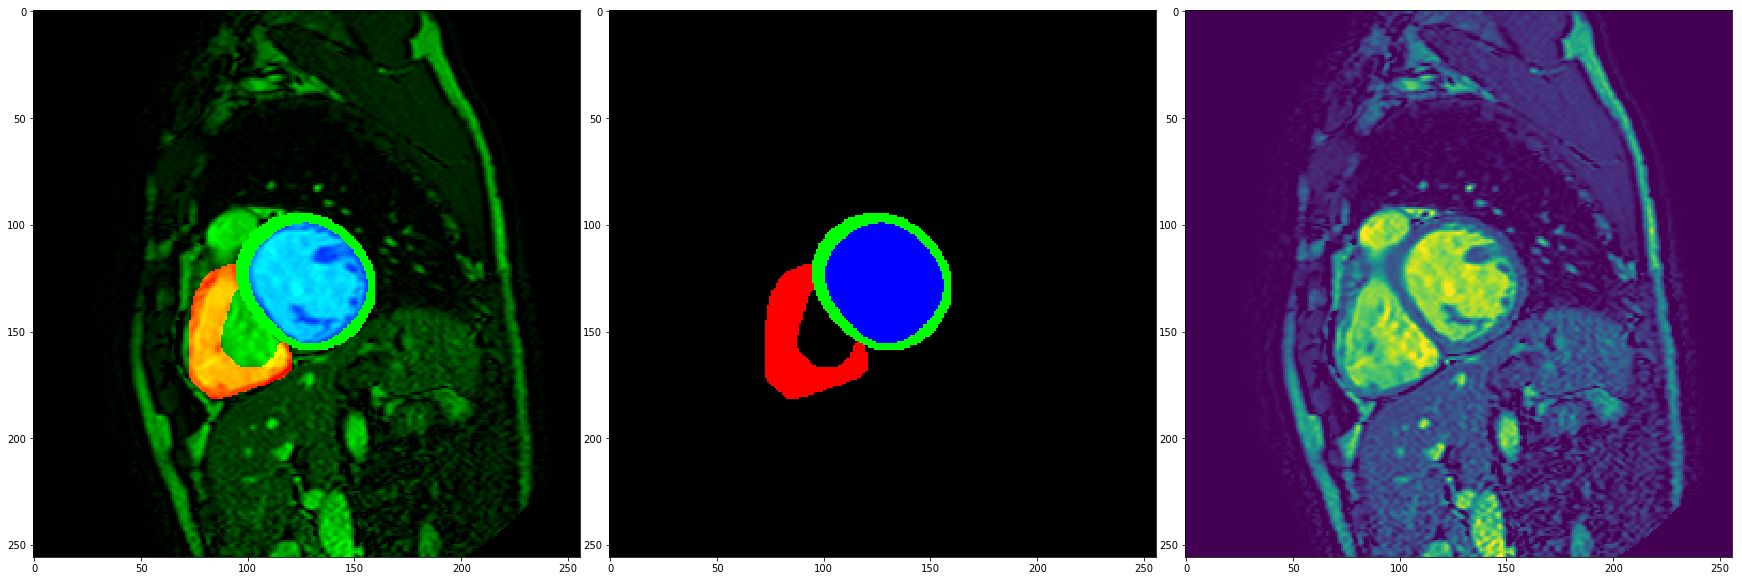

2019-03-16 10:10:23,247 INFO Image-shape: (256, 256)
2019-03-16 10:10:23,247 INFO Image data points: 46273
2019-03-16 10:10:23,263 INFO Image mean: 0.1502255347467257
2019-03-16 10:10:23,265 INFO Image max: 1.0
2019-03-16 10:10:23,265 INFO Image min: 0.0
2019-03-16 10:10:23,265 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:23,265 INFO RV-endo-mask data points: 1370
2019-03-16 10:10:23,265 INFO Myo-mask data points: 904
2019-03-16 10:10:23,265 INFO LV-mask data points: 2326
2019-03-16 10:10:23,265 INFO RV-endo-mask mean: 0.020904541015625
2019-03-16 10:10:23,265 INFO Myo-epi-mask mean: 0.0137939453125
2019-03-16 10:10:23,265 INFO LV-mask mean: 0.035491943359375
2019-03-16 10:10:23,265 INFO Prediction


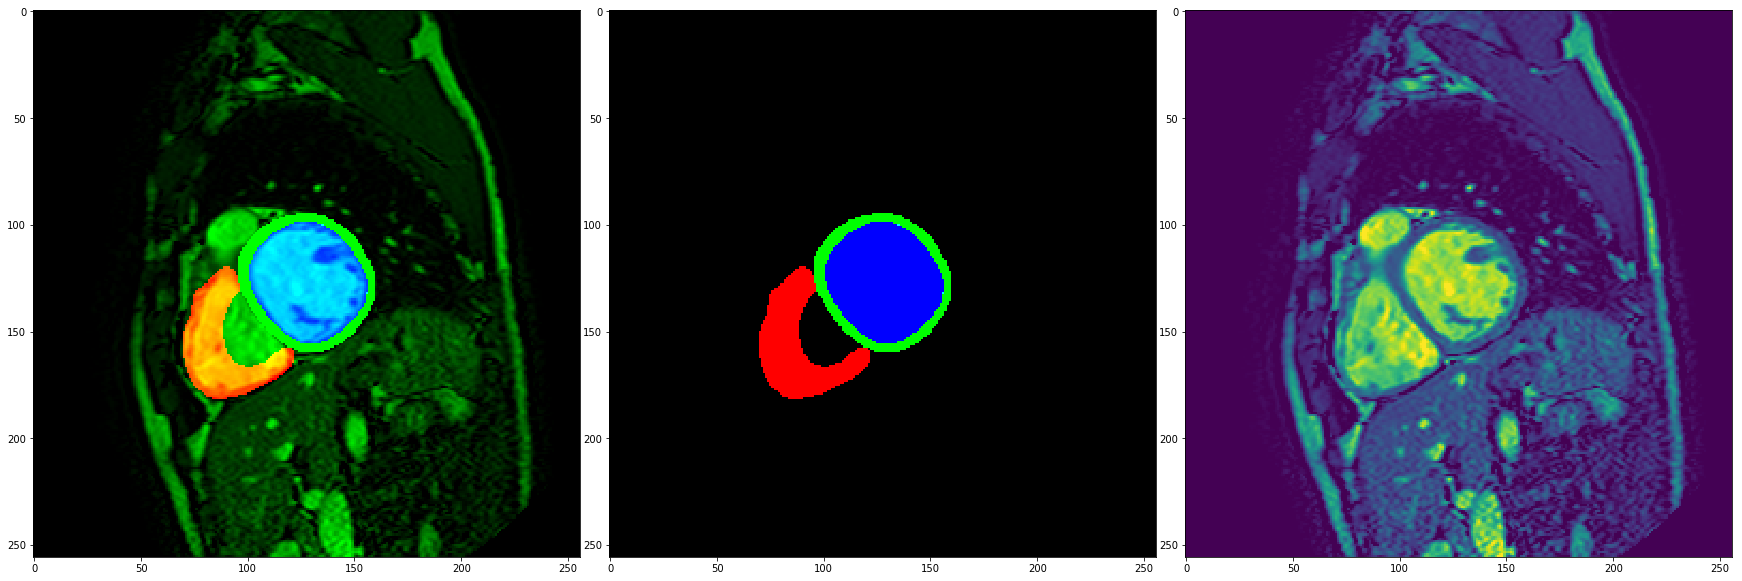

2019-03-16 10:10:24,689 INFO Image-shape: (256, 256)
2019-03-16 10:10:24,689 INFO Image data points: 46273
2019-03-16 10:10:24,689 INFO Image mean: 0.1502255347467257
2019-03-16 10:10:24,689 INFO Image max: 1.0
2019-03-16 10:10:24,689 INFO Image min: 0.0
2019-03-16 10:10:24,689 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:24,689 INFO RV-endo-mask data points: 1434
2019-03-16 10:10:24,705 INFO Myo-mask data points: 841
2019-03-16 10:10:24,705 INFO LV-mask data points: 2331
2019-03-16 10:10:24,705 INFO RV-endo-mask mean: 0.021881103515625
2019-03-16 10:10:24,705 INFO Myo-epi-mask mean: 0.0128326416015625
2019-03-16 10:10:24,705 INFO LV-mask mean: 0.0355682373046875
2019-03-16 10:10:24,705 INFO shape image: (256, 256, 1)
2019-03-16 10:10:24,705 INFO Type: float64
2019-03-16 10:10:24,705 INFO shape pred mask: (256, 256, 3)
2019-03-16 10:10:24,705 INFO Type: bool
2019-03-16 10:10:24,705 INFO shape gt mask: (256, 256, 3)
2019-03-16 10:10:24,705 INFO Type: bool
2019-03-16 10:10:24,705 INFO

---------- validation ----------


2019-03-16 10:10:26,221 INFO Ground-Truth


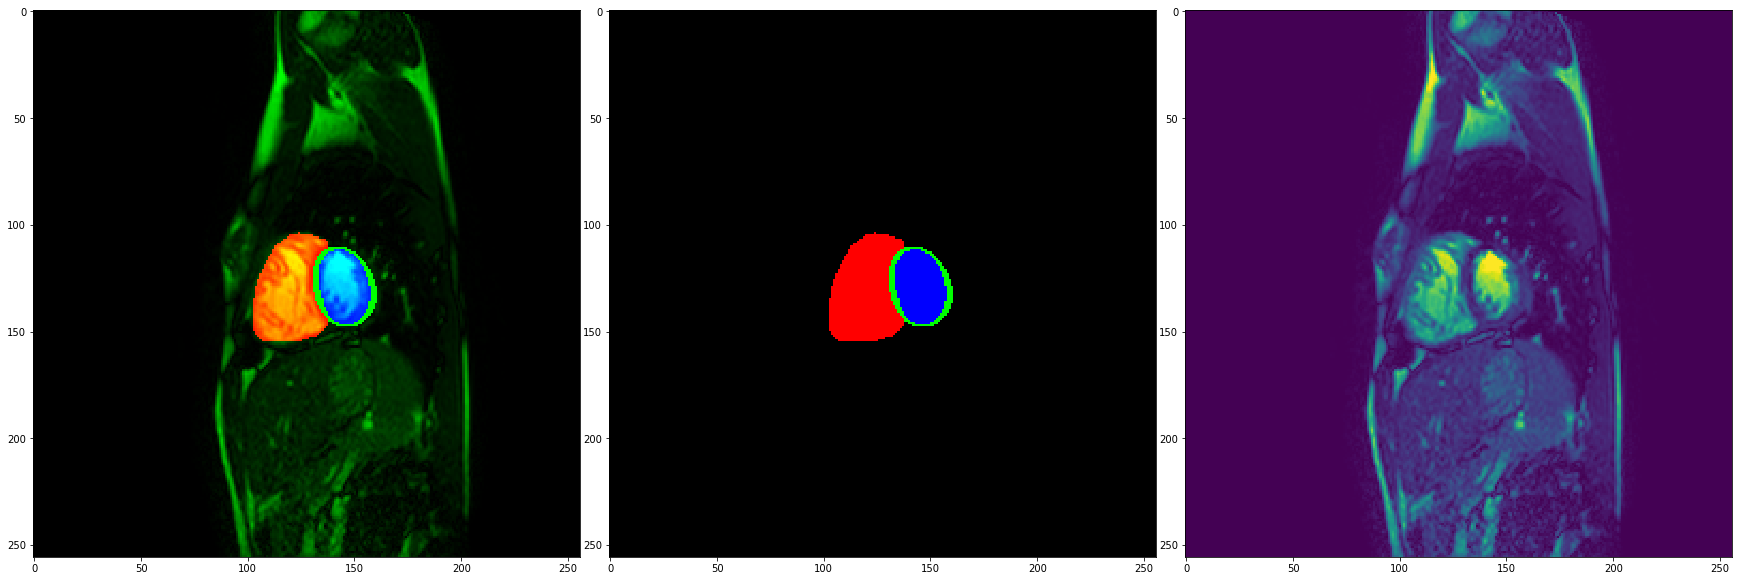

2019-03-16 10:10:27,552 INFO Image-shape: (256, 256)
2019-03-16 10:10:27,569 INFO Image data points: 34832
2019-03-16 10:10:27,569 INFO Image mean: 0.07619035996103171
2019-03-16 10:10:27,569 INFO Image max: 1.0
2019-03-16 10:10:27,569 INFO Image min: 0.0
2019-03-16 10:10:27,569 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:27,569 INFO RV-endo-mask data points: 1338
2019-03-16 10:10:27,584 INFO Myo-mask data points: 221
2019-03-16 10:10:27,584 INFO LV-mask data points: 660
2019-03-16 10:10:27,584 INFO RV-endo-mask mean: 0.020416259765625
2019-03-16 10:10:27,584 INFO Myo-epi-mask mean: 0.0033721923828125
2019-03-16 10:10:27,584 INFO LV-mask mean: 0.01007080078125
2019-03-16 10:10:27,584 INFO Prediction


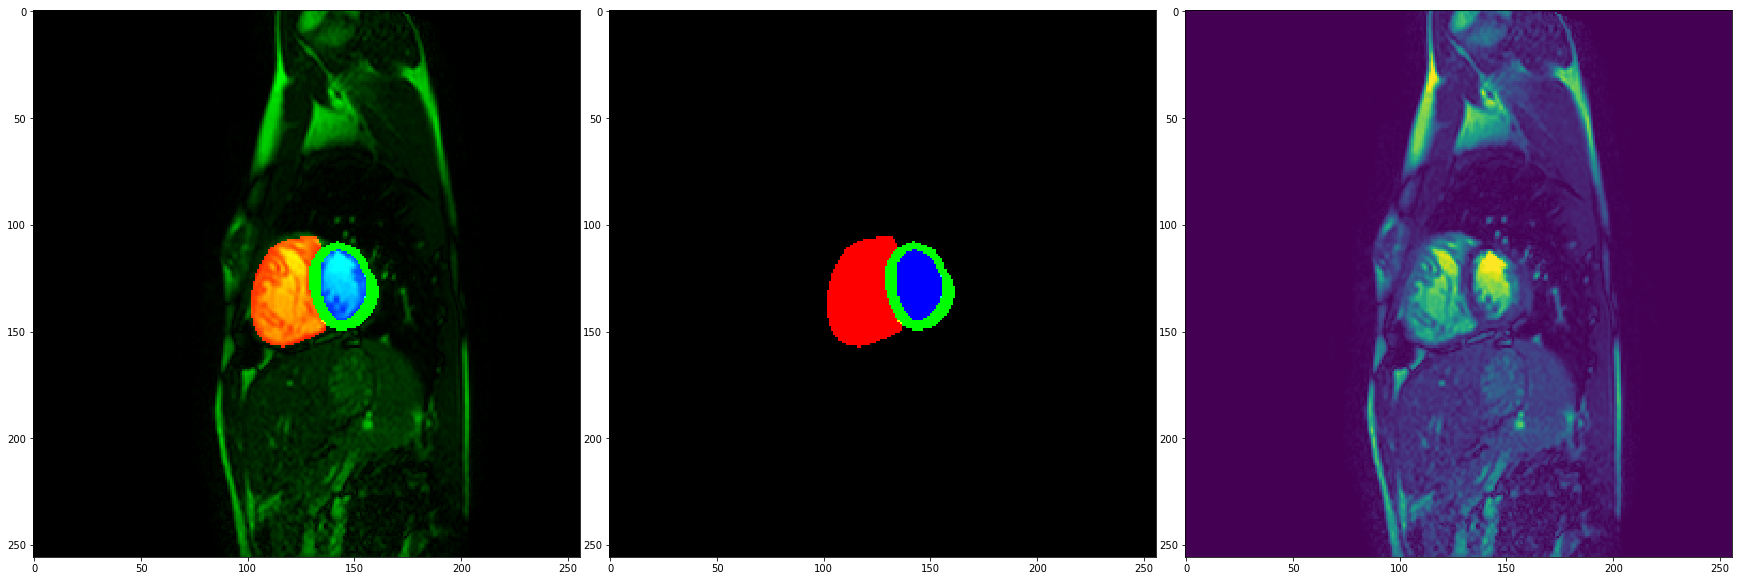

2019-03-16 10:10:28,711 INFO Image-shape: (256, 256)
2019-03-16 10:10:28,727 INFO Image data points: 34832
2019-03-16 10:10:28,743 INFO Image mean: 0.07619035996103171
2019-03-16 10:10:28,743 INFO Image max: 1.0
2019-03-16 10:10:28,743 INFO Image min: 0.0
2019-03-16 10:10:28,743 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:28,743 INFO RV-endo-mask data points: 1312
2019-03-16 10:10:28,743 INFO Myo-mask data points: 491
2019-03-16 10:10:28,743 INFO LV-mask data points: 541
2019-03-16 10:10:28,743 INFO RV-endo-mask mean: 0.02001953125
2019-03-16 10:10:28,743 INFO Myo-epi-mask mean: 0.0074920654296875
2019-03-16 10:10:28,743 INFO LV-mask mean: 0.0082550048828125
2019-03-16 10:10:28,758 INFO shape image: (256, 256, 1)
2019-03-16 10:10:28,758 INFO Type: float64
2019-03-16 10:10:28,758 INFO shape pred mask: (256, 256, 3)
2019-03-16 10:10:28,758 INFO Type: bool
2019-03-16 10:10:28,758 INFO shape gt mask: (256, 256, 3)
2019-03-16 10:10:28,758 INFO Type: bool
2019-03-16 10:10:28,758 INFO dic

---------- test ----------


2019-03-16 10:10:30,323 INFO Ground-Truth


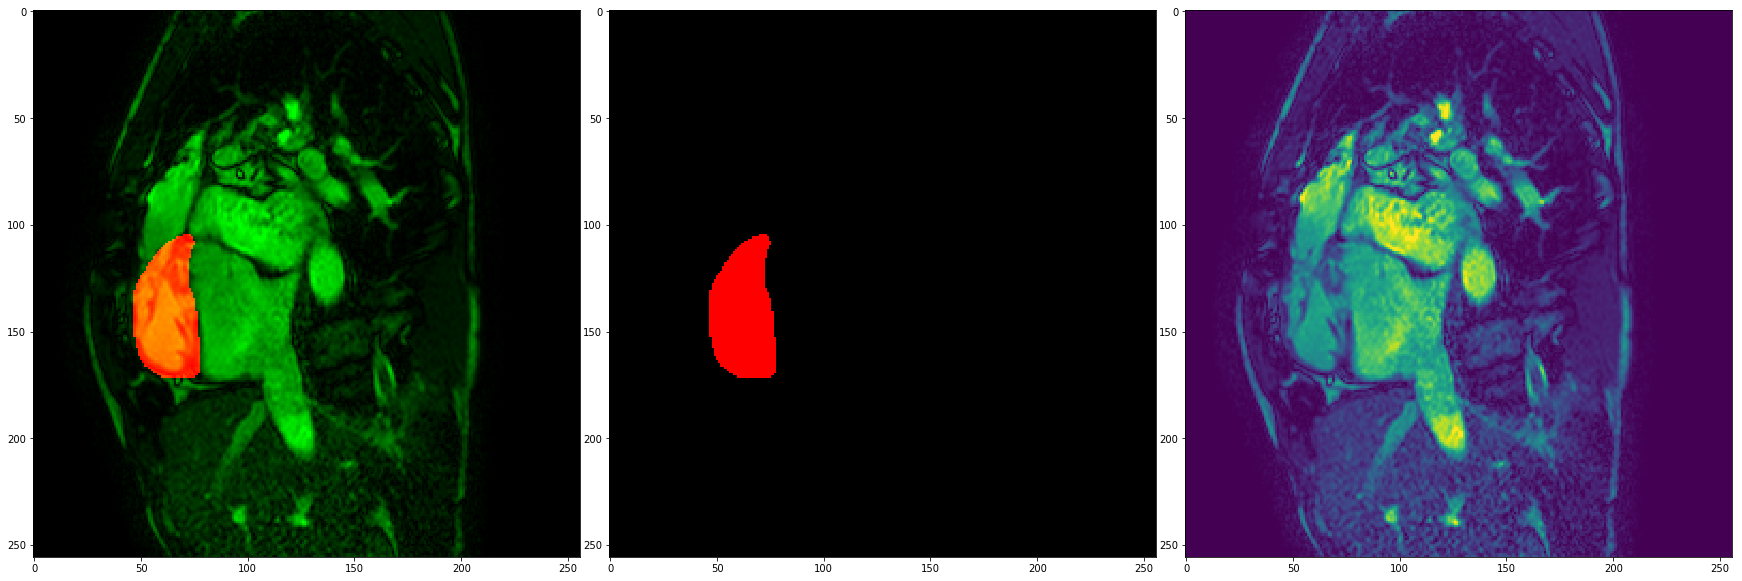

2019-03-16 10:10:31,700 INFO Image-shape: (256, 256)
2019-03-16 10:10:31,700 INFO Image data points: 49491
2019-03-16 10:10:31,700 INFO Image mean: 0.1481766091253547
2019-03-16 10:10:31,700 INFO Image max: 1.0
2019-03-16 10:10:31,700 INFO Image min: 0.0
2019-03-16 10:10:31,700 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:31,700 INFO RV-endo-mask data points: 1620
2019-03-16 10:10:31,700 INFO Myo-mask data points: 0
2019-03-16 10:10:31,700 INFO LV-mask data points: 0
2019-03-16 10:10:31,700 INFO RV-endo-mask mean: 0.02471923828125
2019-03-16 10:10:31,716 INFO Myo-epi-mask mean: 0.0
2019-03-16 10:10:31,716 INFO LV-mask mean: 0.0
2019-03-16 10:10:31,716 INFO Prediction


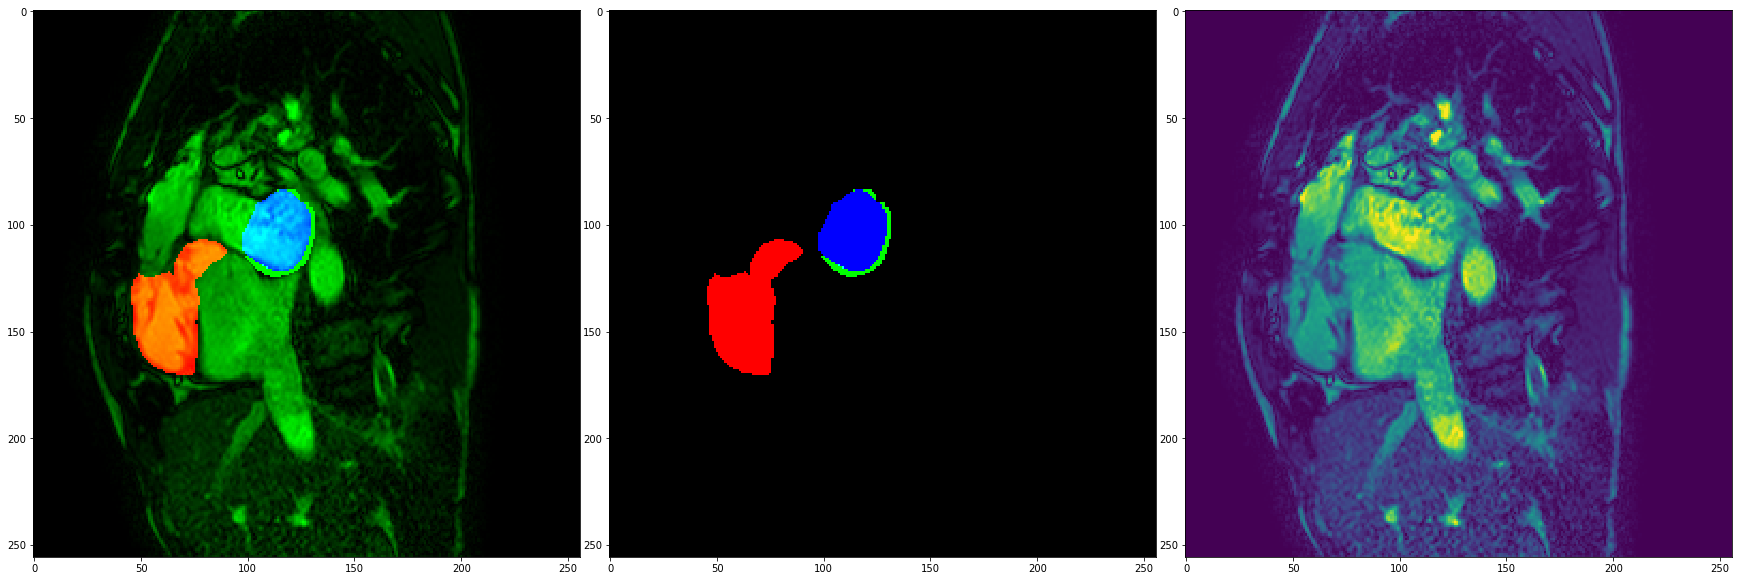

2019-03-16 10:10:33,204 INFO Image-shape: (256, 256)
2019-03-16 10:10:33,219 INFO Image data points: 49491
2019-03-16 10:10:33,219 INFO Image mean: 0.1481766091253547
2019-03-16 10:10:33,235 INFO Image max: 1.0
2019-03-16 10:10:33,235 INFO Image min: 0.0
2019-03-16 10:10:33,235 INFO Mask-shape: (256, 256, 3)
2019-03-16 10:10:33,235 INFO RV-endo-mask data points: 1580
2019-03-16 10:10:33,250 INFO Myo-mask data points: 154
2019-03-16 10:10:33,250 INFO LV-mask data points: 910
2019-03-16 10:10:33,250 INFO RV-endo-mask mean: 0.02410888671875
2019-03-16 10:10:33,250 INFO Myo-epi-mask mean: 0.002349853515625
2019-03-16 10:10:33,250 INFO LV-mask mean: 0.013885498046875
2019-03-16 10:10:33,250 INFO shape image: (256, 256, 1)
2019-03-16 10:10:33,250 INFO Type: float64
2019-03-16 10:10:33,250 INFO shape pred mask: (256, 256, 3)
2019-03-16 10:10:33,250 INFO Type: bool
2019-03-16 10:10:33,250 INFO shape gt mask: (256, 256, 3)
2019-03-16 10:10:33,250 INFO Type: bool
2019-03-16 10:10:33,250 INFO dic

In [108]:
def sanity_check(generator):
    ix = random.randint(0, len(generator))
    ib = random.randint(0, generator.batch_size-1)
    
    
    img = generator.__getitem__(ix)[0][ib]
    pred = model.predict(img[newaxis, :, :, :])
    gt = generator.__getitem__(ix)[1][ib]
    
    # threshold prediction
    pred = pred[0,:,:,:]
    pred = (pred>0.5).astype(np.bool)
    gt = gt.astype(np.bool)
    
    logging.info('Ground-Truth')
    show_slice(img, gt)
    logging.info('Prediction')
    show_slice(img, pred)

    try:
        logging.info('shape image: {}'.format(img.shape))
        logging.info('Type: {}'.format(img.dtype))
        logging.info('shape pred mask: {}'.format(pred.shape))
        logging.info('Type: {}'.format(pred.dtype))
        logging.info('shape gt mask: {}'.format(gt.shape))
        logging.info('Type: {}'.format(gt.dtype))
        
        logging.info('dice medley score: {}'.format(m_metrics.dc(pred, gt)))
        logging.info('dice medley score Myo: {}'.format(m_metrics.dc(pred[:,:,1], gt[:,:,1])))
        logging.info('dice medley score LV: {}'.format(m_metrics.dc(pred[:,:,2], gt[:,:,2])))
        logging.info('dice medley score RV: {}'.format(m_metrics.dc(pred[:,:,0], gt[:,:,0])))
        
        logging.info('hausdorff distance: {}'.format(m_metrics.hd(pred, gt)))
        logging.info('hausdorff distance Myo: {}'.format(m_metrics.hd(pred[:,:,1], gt[:,:,1])))
        logging.info('hausdorff distance LV: {}'.format(m_metrics.hd(pred[:,:,2], gt[:,:,2])))
        logging.info('hausdorff distance RV: {}'.format(m_metrics.hd(pred[:,:,0], gt[:,:,0])))
        
        #pred = pred.astype(np.float16)[np.newaxis]
        #gt = gt.astype(np.float16)[np.newaxis]
        
        # compare own dice score with medpy and acdc dice
        #logging.info('dice score: {}'.format(K.eval(metr.dice_coef(pred, gt))))
        #logging.info('dice score Myo: {}'.format(K.eval(metr.dice_coef_myo(pred, gt))))
        #logging.info('dice score LV: {}'.format(K.eval(metr.dice_coef_lv(pred, gt))))
        #logging.info('dice score RV: {}'.format(K.eval(metr.dice_coef_rv(pred, gt))))
        
        logging.info('Jac medpy score: {}'.format(jc(pred, gt)))
        logging.info('Jac medpy score Myo: {}'.format(jc(pred[:,:,1], gt[:,:,1])))
        logging.info('Jac medpy score LV: {}'.format(jc(pred[:,:,2], gt[:,:,2])))
        logging.info('Jac medpy score RV: {}'.format(jc(pred[:,:,0], gt[:,:,0])))
        
        #logging.info('IOU score: {}'.format(K.eval(metr.iou_core(pred, gt))))
        #logging.info('IOU score Myo: {}'.format(metr.iou_core_myo(pred, gt)))
        #logging.info('IOU score LV: {}'.format(K.eval(metr.iou_core_lv(pred, gt))))
        #logging.info('IOU score RV: {}'.format(K.eval(metr.iou_core_rv(pred, gt))))
    except Exception as e:
        logging.info(str(e))
    



print('{} {} {}'.format('-'*10, 'training', '-'*10))
sanity_check(batch_generator)
print('{} {} {}'.format('-'*10, 'validation', '-'*10))
sanity_check(validation_generator)
print('{} {} {}'.format('-'*10, 'test', '-'*10))
sanity_check(test_generator)

